In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import datetime
import numpy as np
import pandas as pd
from sklearn.preprocessing import LabelEncoder
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import seaborn as sns
from keras.layers import Dense, Dropout
from keras.models import Sequential
from sklearn.metrics import precision_score, recall_score, confusion_matrix, classification_report, accuracy_score, f1_score
from keras import callbacks
from tensorflow.keras.optimizers import Adam

import warnings
warnings.simplefilter("ignore")

In [ ]:
from google.colab import files
uploaded = files.upload()

Saving weatherAUS.csv to weatherAUS (3).csv


In [ ]:
import io
df = pd.read_csv(io.BytesIO(uploaded['weatherAUS.csv']))# Dataset is now stored in a Pandas Dataframe
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 145460 entries, 0 to 145459
Data columns (total 23 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   Date           145460 non-null  object 
 1   Location       145460 non-null  object 
 2   MinTemp        143975 non-null  float64
 3   MaxTemp        144199 non-null  float64
 4   Rainfall       142199 non-null  float64
 5   Evaporation    82670 non-null   float64
 6   Sunshine       75625 non-null   float64
 7   WindGustDir    135134 non-null  object 
 8   WindGustSpeed  135197 non-null  float64
 9   WindDir9am     134894 non-null  object 
 10  WindDir3pm     141232 non-null  object 
 11  WindSpeed9am   143693 non-null  float64
 12  WindSpeed3pm   142398 non-null  float64
 13  Humidity9am    142806 non-null  float64
 14  Humidity3pm    140953 non-null  float64
 15  Pressure9am    130395 non-null  float64
 16  Pressure3pm    130432 non-null  float64
 17  Cloud9am       89572 non-null

In [ ]:
df.isnull().sum()

Date                 0
Location             0
MinTemp           1485
MaxTemp           1261
Rainfall          3261
Evaporation      62790
Sunshine         69835
WindGustDir      10326
WindGustSpeed    10263
WindDir9am       10566
WindDir3pm        4228
WindSpeed9am      1767
WindSpeed3pm      3062
Humidity9am       2654
Humidity3pm       4507
Pressure9am      15065
Pressure3pm      15028
Cloud9am         55888
Cloud3pm         59358
Temp9am           1767
Temp3pm           3609
RainToday         3261
RainTomorrow      3267
dtype: int64

In [ ]:
df['RainTomorrow'].unique()

array(['No', 'Yes', nan], dtype=object)

In [ ]:
# Droping the missing values
df = df.dropna(subset = ['RainTomorrow'])
df['RainTomorrow'].unique()

array(['No', 'Yes'], dtype=object)

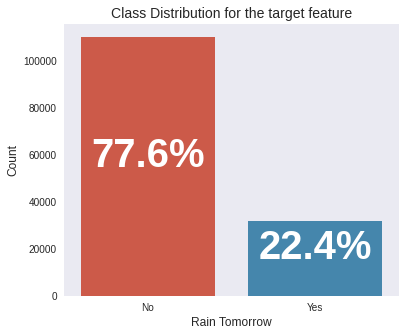

In [ ]:
# Checking for the class imbalance
fig = plt.figure(figsize = (6, 5))
axis = sns.countplot(x = 'RainTomorrow', data = df);
axis.set_title('Class Distribution for the target feature', size = 14);

for patch in axis.patches:
    axis.text(x = patch.get_x() + patch.get_width()/2, y = patch.get_height()/2, 
            s = f"{np.round(patch.get_height()/len(df)*100, 1)}%", 
            ha = 'center', size = 40, rotation = 0, weight = 'bold' ,color = 'white')
    
axis.set_xlabel('Rain Tomorrow', size = 12)
axis.set_ylabel('Count', size = 12);

The class is imbalance when the minority class has only 5-10% data. 
We have 22.4% data belonging to the minority class,
 so, there is no class imbalance. Now, let's look at other features.

I will be creating new features of day and month from Date column, which are cyclic in nature. 
If I do not do any preprocessing on them and directly feed them to ANN, the ANN can give more or less importance based on the values. 
Eg. days will have values from 1 to 31, so ANN thinks that value 31 is more than 1, but actually they are just days so our model can go wrong.
 Thus, I will be performing a transformation on these features to make them cyclic.

A circle is the projection of cyclic pattern. This concept is used here, to make feature transformations.

In [ ]:
# Changing the data types of Date to datetime
df['Date'] = pd.to_datetime(df['Date'])

# months and days in a cyclic continuous feature.
def encode(data, col, max_val):
    data[col + '_sin'] = np.sin(2 * np.pi * data[col]/max_val)
    data[col + '_cos'] = np.cos(2 * np.pi * data[col]/max_val)
    return data

df['month'] = df['Date'].dt.month
df = encode(df, 'month', 12)

df['day'] = df['Date'].dt.day
df = encode(df, 'day', 31)

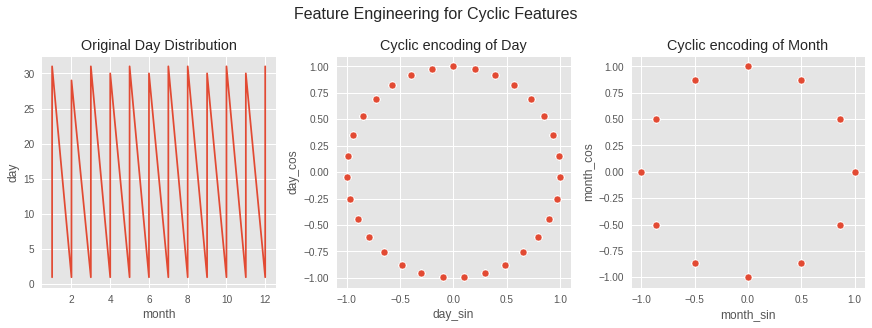

In [ ]:
# Let's look at the transformed features

plt.style.use('ggplot')
fig, (ax1,ax2,ax3) = plt.subplots(1,3, figsize = (12, 4), constrained_layout = True)

ax1 = sns.lineplot(x = 'month', y = 'day', data = df, estimator = None, ax=ax1)
ax2 = sns.scatterplot(x = 'day_sin', y = 'day_cos', data = df, ax = ax2)
ax3 = sns.scatterplot(x = 'month_sin', y = 'month_cos', data = df, ax = ax3)

ax1.set_title('Original Day Distribution')
ax2.set_title('Cyclic encoding of Day')
ax3.set_title('Cyclic encoding of Month')

fig.suptitle('Feature Engineering for Cyclic Features', size = 16, y = 1.1);

In [ ]:
# Let's first handle missing values for catergorical data
categorical_col = df.select_dtypes('object').columns[:-1].to_list()
df[categorical_col].isnull().mean()*100

Location       0.000000
WindGustDir    6.561504
WindDir9am     7.041838
WindDir3pm     2.656952
RainToday      0.988797
dtype: float64

As the missing values are less than 10%, impute them with the mode.

In [ ]:
# Filling missing values with the mode
for i in categorical_col:
  df[i].fillna(df[i].mode()[0], inplace=True)

df[categorical_col].isnull().mean()*100

Location       0.0
WindGustDir    0.0
WindDir9am     0.0
WindDir3pm     0.0
RainToday      0.0
dtype: float64

In [ ]:
# Missing values for numeric data
numeric_col = df.describe().columns.to_list()
df[numeric_col].isnull().mean()*100

MinTemp           0.447983
MaxTemp           0.226453
Rainfall          0.988797
Evaporation      42.789026
Sunshine         47.692924
WindGustSpeed     6.519308
WindSpeed9am      0.948007
WindSpeed3pm      1.849599
Humidity9am       1.247600
Humidity3pm       2.538803
Pressure9am       9.855619
Pressure3pm       9.832411
Cloud9am         37.735332
Cloud3pm         40.152469
Temp9am           0.635756
Temp3pm           1.917113
month             0.000000
month_sin         0.000000
month_cos         0.000000
day               0.000000
day_sin           0.000000
day_cos           0.000000
dtype: float64

Evaporation, Sunshine, Cloud9am and Cloud3pm have large missing values, so we will first look at these features and then handle the missing values for remaing numeric features.

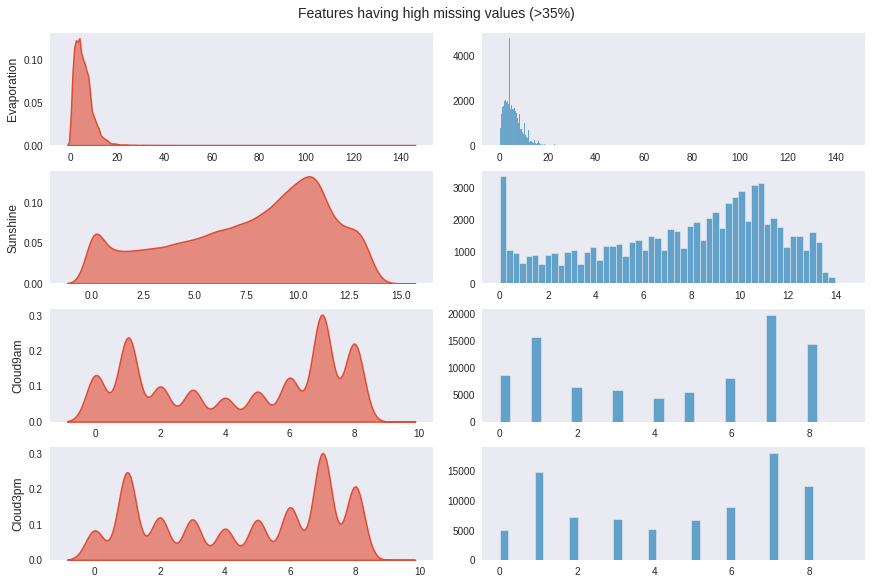

In [ ]:
# Let's explore the features having high missing values
cols = ['Evaporation', 'Sunshine', 'Cloud9am', 'Cloud3pm']

plt.style.use('seaborn-dark')
fig, ax = plt.subplots(4,2, figsize = (12, 8), constrained_layout = True)

for i, num_var in enumerate(cols): 
    sns.kdeplot(data = df, x = num_var, ax = ax[i][0],
                fill = True, alpha = 0.6, linewidth = 1.5)
    ax[i][0].set_ylabel(num_var)
    ax[i][0].set_xlabel(None)
    
    sns.histplot(data = df, x = num_var, ax = ax[i][1])
    ax[i][1].set_ylabel(None)
    ax[i][1].set_xlabel(None)
    
fig.suptitle('Features having high missing values (>35%)', size = 14);

In [ ]:
#Impute the missing values with the median for Evaporation
df['Evaporation'].fillna(df['Evaporation'].mean(), inplace = True)

In [ ]:
# Droping the columns with high missing values (>35%) and distributed data
df.drop(columns = ['Sunshine', 'Cloud9am', 'Cloud3pm'], axis=1, inplace = True)

In [ ]:
# Missing values for numeric data
numeric_col = df.describe().columns.to_list()
df[numeric_col].isnull().mean()*100

MinTemp          0.447983
MaxTemp          0.226453
Rainfall         0.988797
Evaporation      0.000000
WindGustSpeed    6.519308
WindSpeed9am     0.948007
WindSpeed3pm     1.849599
Humidity9am      1.247600
Humidity3pm      2.538803
Pressure9am      9.855619
Pressure3pm      9.832411
Temp9am          0.635756
Temp3pm          1.917113
month            0.000000
month_sin        0.000000
month_cos        0.000000
day              0.000000
day_sin          0.000000
day_cos          0.000000
dtype: float64

In [ ]:
# Removing the missing values from the remaining numerical features as they are <9%.
numeric_col = ['MinTemp', 'MaxTemp', 'Rainfall','WindGustSpeed', 'WindSpeed9am', 'WindSpeed3pm',
               'Humidity9am','Humidity3pm', 'Temp9am', 'Temp3pm']

for col in numeric_col:
  df = df.dropna(subset = [col])

In [ ]:
# Imputing missing values with median for 2 columns
for col in ['Pressure9am','Pressure3pm']:
  df[col].fillna(df[col].median(), inplace = True)

In [ ]:
# Missing values for numeric data
numeric_col = df.describe().columns.to_list()
df[numeric_col].isnull().mean()*100

Location         0.0
MinTemp          0.0
MaxTemp          0.0
Rainfall         0.0
Evaporation      0.0
WindGustDir      0.0
WindGustSpeed    0.0
WindDir9am       0.0
WindDir3pm       0.0
WindSpeed9am     0.0
WindSpeed3pm     0.0
Humidity9am      0.0
Humidity3pm      0.0
Pressure9am      0.0
Pressure3pm      0.0
Temp9am          0.0
Temp3pm          0.0
RainToday        0.0
RainTomorrow     0.0
month            0.0
month_sin        0.0
month_cos        0.0
day              0.0
day_sin          0.0
day_cos          0.0
dtype: float64

In [ ]:
# shuffle the DataFrame rows
df = df.sample(frac = 1)
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 129246 entries, 74170 to 108453
Data columns (total 26 columns):
 #   Column         Non-Null Count   Dtype         
---  ------         --------------   -----         
 0   Date           129246 non-null  datetime64[ns]
 1   Location       129246 non-null  int64         
 2   MinTemp        129246 non-null  float64       
 3   MaxTemp        129246 non-null  float64       
 4   Rainfall       129246 non-null  float64       
 5   Evaporation    129246 non-null  float64       
 6   WindGustDir    129246 non-null  int64         
 7   WindGustSpeed  129246 non-null  float64       
 8   WindDir9am     129246 non-null  int64         
 9   WindDir3pm     129246 non-null  int64         
 10  WindSpeed9am   129246 non-null  float64       
 11  WindSpeed3pm   129246 non-null  float64       
 12  Humidity9am    129246 non-null  float64       
 13  Humidity3pm    129246 non-null  float64       
 14  Pressure9am    129246 non-null  float64       
 

*The end of Filling missing data.
===============================================

In [ ]:
# Apply label encoder to each column with categorical data
# View list of categorical variables
s = (df.dtypes == "object")
object_cols = list(s[s].index)
label_encoder = LabelEncoder()
for i in object_cols:
  df[i] = label_encoder.fit_transform(df[i])

In [ ]:
# Preparing attributes of scale data
# Dropping extra columns
features = df.drop(['RainTomorrow','Date', 'day', 'month', 'month_sin','month_cos','day_sin','day_cos'], axis=1)

# Defining our target columns
target = df['RainTomorrow']

# Set up a standard scaler for the features
col_names = list(features.columns)
s_scaler = preprocessing.StandardScaler()
features = s_scaler.fit_transform(features)
features = pd.DataFrame(features, columns=col_names)

features.describe().T

,count,mean,std,min,25%,50%,75%,max
Location,129246.0,-2.295248e-17,1.000004,-1.656216,-0.854050,0.021040,0.823206,1.698296
MinTemp,129246.0,3.817533e-16,1.000004,-3.204471,-0.717935,-0.034138,0.727364,3.384850
MaxTemp,129246.0,5.498699e-16,1.000004,-3.936480,-0.754079,-0.067129,0.717956,3.479775
Rainfall,129246.0,6.817023e-17,1.000004,-0.275503,-0.275503,-0.275503,-0.203586,43.785857
Evaporation,129246.0,-9.785727e-17,1.000004,-1.719624,-0.467112,-0.006869,-0.006869,24.082114
WindGustDir,129246.0,7.982514e-17,1.000004,-1.659032,-0.800028,0.058976,0.917979,1.562232
WindGustSpeed,129246.0,5.189734e-17,1.000004,-2.503366,-0.661073,-0.071539,0.591687,7.002866
WindDir9am,129246.0,-2.199040e-18,1.000004,-1.554673,-0.892419,-0.009413,0.873593,1.756599
WindDir3pm,129246.0,-7.278822e-17,1.000004,-1.692282,-0.821580,0.049121,0.919823,1.572849
WindSpeed9am,129246.0,-8.994073e-17,1.000004,-1.617324,-0.819719,-0.136058,0.661547,8.295765


so shuffle data and train/test/validation

In [ ]:
from sklearn.model_selection import train_test_split

# Splitting the data into train and test
df_train, df_test, target_train, target_test = train_test_split(features, target, test_size = 0.2, random_state = 42)
# Split the train and the validation set for the fitting


print(df.shape)
print("train shape: ",df_train.shape, target_train.shape)
print("test shape: ",df_test.shape, target_test.shape)

(129246, 26)
train shape:  (103396, 18) (103396,)
test shape:  (25850, 18) (25850,)


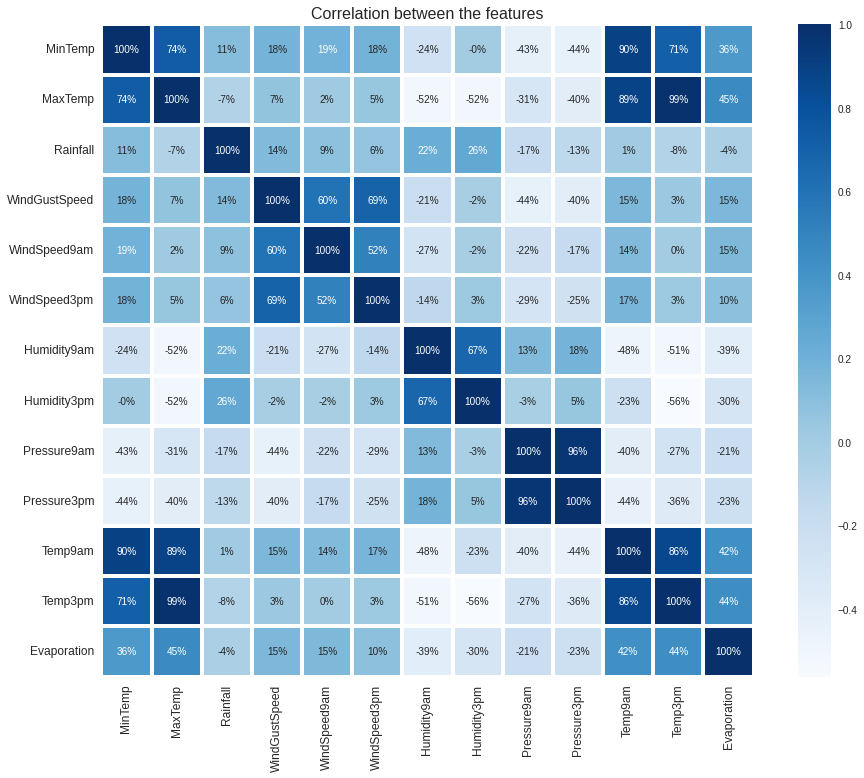

In [ ]:
# Checking for the correlation between the numeric features
# Correlation between numeric variables

numeric_col = ['MinTemp', 'MaxTemp', 'Rainfall','WindGustSpeed', 'WindSpeed9am', 'WindSpeed3pm',
               'Humidity9am','Humidity3pm', 'Pressure9am', 'Pressure3pm', 'Temp9am', 'Temp3pm',
               'Evaporation']

fig=plt.figure(figsize=(16,12))
axis=sns.heatmap(df_train[numeric_col].corr(), annot=True, linewidths=3, square=True, cmap='Blues', fmt=".0%")

axis.set_title('Correlation between the features', fontsize=16);
axis.set_xticklabels(numeric_col, fontsize=12)
axis.set_yticklabels(numeric_col, fontsize=12, rotation=0);

In [ ]:
Numerical = [var for var  in df_train.columns if df_train[var].dtype !='O' ]
sns.pairplot(df_train[Numerical], kind = 'scatter', diag_kind = 'hist', palette = 'Rainbow')
plt.show()

In [ ]:
# Droping the columns
for data in [df_train, df_test]:
  data.drop(columns = ['Temp3pm', 'Pressure9am'], axis=1, inplace = True)

In [ ]:
from sklearn.feature_selection import SequentialFeatureSelector
from sklearn.feature_selection import SelectFromModel
from time import time
from sklearn import linear_model
# Dropping extra columns

ridge = linear_model.Ridge (alpha = .5)
#features_train = df_train.drop([ 'Date','day', 'month', 'month_sin','month_cos','day_sin','day_cos'], axis=1)

tic_fwd = time()
sfs_forward = SequentialFeatureSelector(ridge, n_features_to_select=14, direction="forward").fit(df_train, target_train)
toc_fwd = time()

feature_names = np.array(df_train.columns)
print(sfs_forward )
print(sfs_forward.get_support())
print("\n","Features selected by forward sequential selection: ",feature_names[sfs_forward.get_support()])

SequentialFeatureSelector(estimator=Ridge(alpha=0.5), n_features_to_select=14)
[ True  True  True  True  True False  True  True False  True  True  True
  True  True  True  True]

 Features selected by forward sequential selection:  ['Location' 'MinTemp' 'MaxTemp' 'Rainfall' 'Evaporation' 'WindGustSpeed'
 'WindDir9am' 'WindSpeed9am' 'WindSpeed3pm' 'Humidity9am' 'Humidity3pm'
 'Pressure3pm' 'Temp9am' 'RainToday']


In [ ]:
df_train = df_train.drop(['WindGustDir','WindDir3pm'], axis=1)
df_test = df_test.drop(['WindGustDir','WindDir3pm'], axis=1)

In [ ]:
df_train.info()
target_train.shape

<class 'pandas.core.frame.DataFrame'>
Int64Index: 103396 entries, 108465 to 121958
Data columns (total 14 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   Location       103396 non-null  float64
 1   MinTemp        103396 non-null  float64
 2   MaxTemp        103396 non-null  float64
 3   Rainfall       103396 non-null  float64
 4   Evaporation    103396 non-null  float64
 5   WindGustSpeed  103396 non-null  float64
 6   WindDir9am     103396 non-null  float64
 7   WindSpeed9am   103396 non-null  float64
 8   WindSpeed3pm   103396 non-null  float64
 9   Humidity9am    103396 non-null  float64
 10  Humidity3pm    103396 non-null  float64
 11  Pressure3pm    103396 non-null  float64
 12  Temp9am        103396 non-null  float64
 13  RainToday      103396 non-null  float64
dtypes: float64(14)
memory usage: 11.8 MB


(103396,)

In [ ]:
# Early stopping

early_stopping = callbacks.EarlyStopping(
    min_delta=0.001, #minimum amount of change to count as an improvement
    patience=20, # how many epochs to wait before stopping
    restore_best_weights=True,
)

# Initialising the NN
model = Sequential()

# Layers

model.add(Dense(units = 32, kernel_initializer = 'uniform', activation = 'relu', input_dim = 14))
model.add(Dropout(0.25))
model.add(Dense(units = 16, kernel_initializer = 'uniform', activation = 'relu'))
model.add(Dropout(0.5))
model.add(Dense(units = 1, kernel_initializer = 'uniform', activation = 'sigmoid'))

# Compiling the ANN
opt = Adam(learning_rate=0.00009)
model.compile(optimizer = opt, loss = 'binary_crossentropy', metrics = ['accuracy'])

# Train the ANN

history = model.fit(df_train, target_train, batch_size = 100, epochs = 55, callbacks=[early_stopping], validation_split= 0.2)

Epoch 1/55
828/828 [==============================] - 4s 4ms/step - loss: 0.6177 - accuracy: 0.7827 - val_loss: 0.4705 - val_accuracy: 0.8191
Epoch 2/55
828/828 [==============================] - 2s 2ms/step - loss: 0.4338 - accuracy: 0.8265 - val_loss: 0.3856 - val_accuracy: 0.8386
Epoch 3/55
828/828 [==============================] - 2s 3ms/step - loss: 0.4042 - accuracy: 0.8357 - val_loss: 0.3711 - val_accuracy: 0.8438
Epoch 4/55
828/828 [==============================] - 2s 3ms/step - loss: 0.3950 - accuracy: 0.8389 - val_loss: 0.3643 - val_accuracy: 0.8469
Epoch 5/55
828/828 [==============================] - 2s 2ms/step - loss: 0.3909 - accuracy: 0.8417 - val_loss: 0.3605 - val_accuracy: 0.8490
Epoch 6/55
828/828 [==============================] - 2s 2ms/step - loss: 0.3876 - accuracy: 0.8430 - val_loss: 0.3579 - val_accuracy: 0.8498
Epoch 7/55
828/828 [==============================] - 2s 2ms/step - loss: 0.3837 - accuracy: 0.8445 - val_loss: 0.3560 - val_accuracy: 0.8508
Epoch 

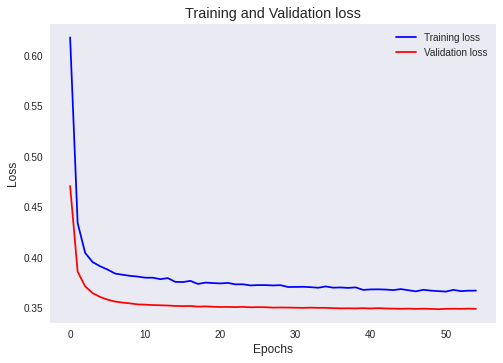

In [ ]:
history_df = pd.DataFrame(history.history)

plt.plot(history_df.loc[:, ['loss']], "#BDE2E2", label='Training loss', color="b")
plt.plot(history_df.loc[:, ['val_loss']],"#C2C4E2", label='Validation loss', color="r")
plt.title('Training and Validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(loc="best")

plt.show()

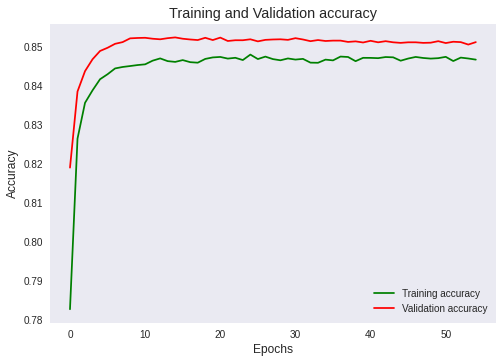

In [ ]:
history_df = pd.DataFrame(history.history)

plt.plot(history_df.loc[:, ['accuracy']], "#BDE2E2", label='Training accuracy', color="g")
plt.plot(history_df.loc[:, ['val_accuracy']], "#C2C4E2", label='Validation accuracy', color="r")

plt.title('Training and Validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [ ]:
# Predicting the test set results
y_pred = model.predict(df_test)
y_pred = (y_pred > 0.5)

In [ ]:
print(classification_report(target_test, y_pred))

              precision    recall  f1-score   support

           0       0.87      0.96      0.91     20305
           1       0.75      0.48      0.58      5545

    accuracy                           0.85     25850
   macro avg       0.81      0.72      0.75     25850
weighted avg       0.84      0.85      0.84     25850



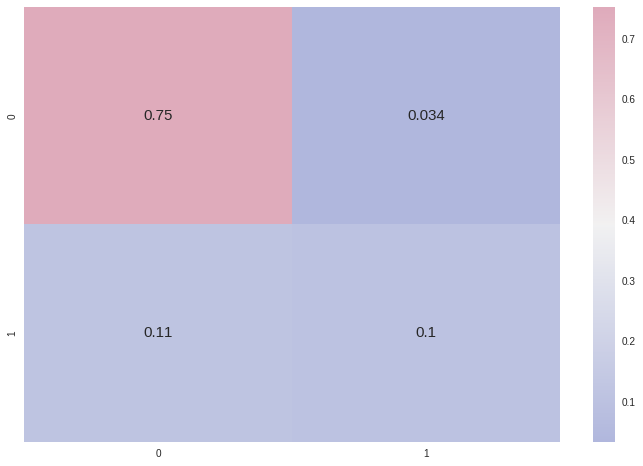

In [ ]:
# confusion matrix
cmap1 = sns.diverging_palette(260,-10,s=50,l=75,n=5, as_cmap=True)
plt.subplots(figsize=(12,8))
cf_matrix = confusion_matrix(target_test,y_pred)
sns.heatmap(cf_matrix/np.sum(cf_matrix), cmap = cmap1, annot = True, annot_kws = {'size':15})